# Wskaźnik giełdowy MACD
Miłosz Chojnacki, 184934

Wszystkie dane użyte do projektu, zostały uzyskane przez API, które udostępnia serwis [Binance](https://www.binance.com/).
Jako obiekt testowy przyjęto, ostatnio bardzo popularną, kryptowalutę [Bitcoin](https://pl.wikipedia.org/wiki/Bitcoin).

## Importy oraz konfigurowanie dostępu do API Binance

In [1]:
from binance.spot import Spot as Client
import pandas as pd
import matplotlib.pyplot as plt
from configparser import ConfigParser

config = ConfigParser()
config.read("config.ini")

api_key = config["binance"]["api_key"]
api_key_secret = config["binance"]["api_key_secret"]

client = Client(key=api_key, secret=api_key_secret)

## Pobranie danych
Pobrane dane przedstawiają kliny *ang. klines (Candle Data)*. Zawierają one informacje o cenach z ostatnich 1000 godzin. Wszystkie późniejsze obliczenia bazują na cenie otwarcia z danego dnia. 


![Klines](/home/buzeqq/MACD/images/historical_kline_return.jpg)
![candle data](/home/buzeqq/MACD/images/img_5d3b7947deecd.png)

In [2]:
limit = 1000
klines = client.klines("BTCUSDT", "1h", limit=limit)

## Preprocesing danych

In [3]:
klines_df = pd.DataFrame(klines)
klines_df.columns = ["Open time", "Open", "High", "Low", "Close", "Volume", "Close time", "Quote asset volume", "No of trades", "TB base asset volume", "TB quote asset volume", "Ignore"]

klines_df["Open time"] = pd.to_datetime(klines_df["Open time"]/1000, unit="s")
klines_df["Close time"] = pd.to_datetime(klines_df["Close time"]/1000, unit="s")

numeric_values = ["Open", "High", "Low", "Close", "Volume", "Quote asset volume", "TB base asset volume", "TB quote asset volume"]
klines_df[numeric_values] = klines_df[numeric_values].apply(pd.to_numeric, axis=1)

## Wizualizacja danych wejściowych
Wykres wartości bitcoina sprzed ostatnich 1000 godzin

<AxesSubplot:title={'center':'BTCUSDT, last 1000 hours'}, xlabel='Open time', ylabel='Open'>

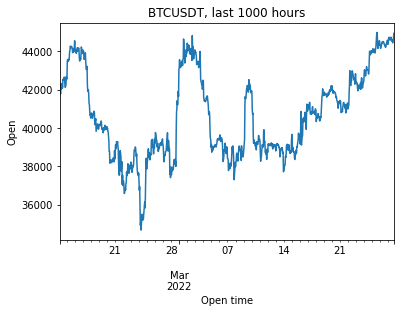

In [4]:
klines_df.plot(x="Open time", y="Open", title="BTCUSDT, last 1000 hours", legend=False, ylabel="Open")

## Implementacja funkcji obliczającej EMA
Ema jest liczona ze wzoru: 

![wzor.png](/home/buzeqq/MACD/images/wzor.png)  
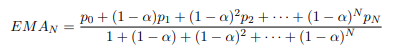

In [5]:
def ema(values: pd.Series, n: int):
    size = klines_df.shape[0]
    result = []
    
    for i in range(0, size):
        first = 0 if i < 12 else i - 12    
        current = pd.Series(values[first:i+1].to_list(), index=range(0, i+1 - first))
        result.append(calculate(current, n))
        
    return pd.Series(result)

Poniższa funkcja oblicza wartość ema dla pojedynczego dnia

In [6]:
def calculate(values: pd.Series, n: int):
    alpha = 2 / (n + 1)
    factors = []
    
    for i in range(0, values.size):
        factors.insert(0, (1 - alpha) ** i)
        
    series_factors = pd.Series(factors, index=range(0, len(factors)))
    numerator = (values * series_factors).sum()
    denominator = series_factors.sum()
    
    return numerator / denominator

Wizualizacja EMA12 dla całego okresu oraz porównanie z implementacją EMA12 z biblioteki pandas

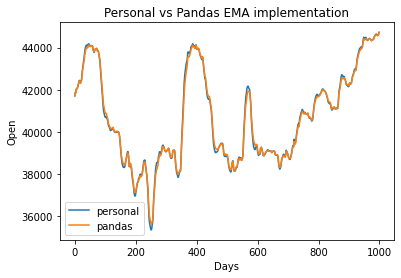

In [7]:
open_s = klines_df["Open"]

ema(open_s, 12).plot(xlabel="Days", ylabel="Open")

klines_df["Open"].ewm(span=12).mean().plot(title="Personal vs Pandas EMA implementation").legend(["personal", "pandas"])

## Wizualizacja wskaźnika MACD oraz SIGNAL dla ostatnich 24 godzin

<AxesSubplot:title={'center':'Open value, thorugh last 24 hours'}, xlabel='Open time'>

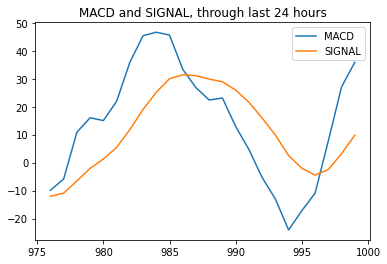

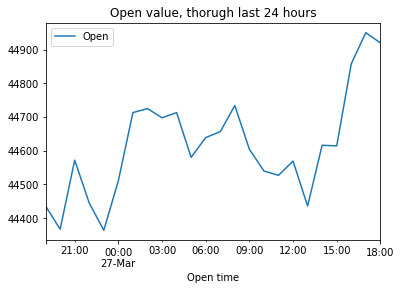

In [8]:
hours_limit = 24
macd = ema(open_s, 12) - ema(open_s, 26)
signal = ema(macd, 9)

macd.tail(hours_limit).plot()
signal.tail(hours_limit).plot(title="MACD and SIGNAL, through last 24 hours").legend(["MACD", "SIGNAL"])
klines_df.tail(hours_limit).plot(x="Open time", y="Open", title="Open value, thorugh last 24 hours")

Na powyższych wykresach, widać że **MACD** jest w stanie przewidzieć wzrost jak i upadek na wartości akcji, ale nie robi tego optymalnie.

## Linia trendu EMA200
Linia trendu wykorzystamy jako dodaktowy wskaźnik podczas implementacji algorytmu inwestującego.

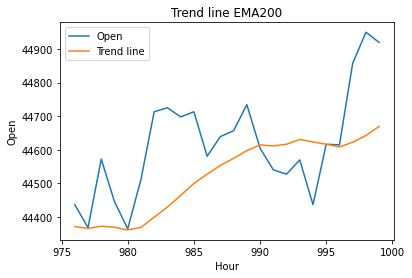

In [9]:
klines_df["Open"].tail(hours_limit).plot()
trend_line = ema(open_s, 200)
trend_line.tail(hours_limit).plot(title="Trend line EMA200", xlabel="Hour", ylabel="Open").legend(["Open", "Trend line"])

## Implementacja algorytmu inwestującego

In [10]:
def trading_simulation(values: pd.Series, macd_s: pd.Series, signal_s: pd.Series, capital: int, advanced: bool=False):
    btc = 0.0
    buy_sell_hours = []

    for hour in range(1, macd_s.size):
        prev_hour_dif = macd_s[hour - 1] - signal_s[hour - 1]
        curr_hour_dif = macd_s[hour] - signal_s[hour]
        
        if prev_hour_dif > 0 and curr_hour_dif <= 0:
            if (values.iloc[hour] > trend_line[hour] or macd_s[hour] > 0) and advanced:
                continue

            income = values.iloc[hour] * btc
            btc = 0.0
            capital += income
            if income != 0:
                buy_sell_hours.append(("SELL", hour))
                sold = True
                
        elif prev_hour_dif < 0 and curr_hour_dif >= 0:
            if (values.iloc[hour] < trend_line[hour] or macd_s[hour] < 0) and advanced:
               continue
            
            purchase_amount = capital / 1000
            capital -= purchase_amount
            btc += purchase_amount / values[hour]
            buy_sell_hours.append(("BUY", hour))
            sold = False
            
    if btc != 0.0:
        income = values[macd_s.size - 1] * btc
        capital += income
        buy_sell_hours.append(("SELL", macd_s.size - 1))
    
    return capital, buy_sell_hours

### Zasady działania
1. Podstawowe zasady kupowania i sprzedawania, kupujemy gdy **MACD** przecina **SIGNAL** od dołu, a sprzedajemy gdy **MACD** przecina **SIGNAL** od góry.
2. Zawsze podążamy za trendem, czyli nie sprzedajemy, gdy trend jest malejący i nie kupujemy, gdy trend jest rosnący. Linie trendu wyznaczamy za pomocą **EMA200**.
3. Kupujemy tylko wtedy gdy wskaźnik **MACD** jest poniżej 0, a sprzedajemy tylko gdy jest powyżej 0.


In [11]:
start_capital = 1000
simple_end_capital, buy_sell_days = trading_simulation(open_s, macd, signal, start_capital)

print("Simple implementation:")
print("Capital after simulation:", round(simple_end_capital, 2))
print("Income:", round(simple_end_capital - start_capital, 2), "(" + str(round((simple_end_capital / start_capital - 1) * 100, 2)) + "%)")

advanced_end_capital, _ = trading_simulation(open_s, macd, signal, start_capital, True)
print("Advanced implementation:")
print("Capital after simulation:", round(advanced_end_capital, 2))
print("Income:", round(advanced_end_capital - start_capital, 2), "(" + str(round((advanced_end_capital / start_capital - 1) * 100, 2)) + "%)")

Simple implementation:
Capital after simulation: 1000.03
Income: 0.03 (0.0%)
Advanced implementation:
Capital after simulation: 1000.47
Income: 0.47 (0.05%)


## Generowanie danych do analizy

In [12]:
for i in range(0, len(buy_sell_days), 2):
    buy_day = buy_sell_days[i][1]
    sell_day = buy_sell_days[i+1][1]

    aoi_open = klines_df.iloc[buy_day - 3:sell_day + 4]
    aoi_macd = macd.iloc[buy_day - 3:sell_day + 4]
    aoi_signal = signal.iloc[buy_day - 3:sell_day + 4]

    plt.plot(aoi_open.index, "Open", data=aoi_open)
    plt.plot(buy_day, aoi_open.at[buy_day, "Open"], "go")
    plt.plot(sell_day, aoi_open.at[sell_day, "Open"], "ro")
    plt.savefig("./output/OPEN-" + str(i) + "-output-" + str(buy_day) + "-" + str(sell_day) + ".jpg")
    plt.close()
    aoi_macd.plot()
    aoi_signal.plot()
    plt.savefig("./output/MACD-" + str(i) + "-output-" + str(buy_day) + "-" + str(sell_day) + ".jpg")
    plt.close()

## Analiza
Analizując wszystkie wykresy, można zauważyć, że sygnały do kupna/sprzedaży są spóźnione, co zmniejsza zyski, a w najgorszych przypadkach generuje straty. Można również zaobserwować, że gdy **macd** oraz **signal** osiągają wartości bliskie zera lub ujemne, sygnały potrafią generować poważne straty.

Podsumowując, wskaźnik **macd** nie nadaje się do "*tradingu*", czyli częstego kupna i sprzedaży, a raczej do inwestowania długoterminowego.

## Przykłady
Górny wykres przedstawia macd oraz signal, a poniższy cene otwarcia wraz z zaznaczonymi momentami kupna i sprzedaży

1. ![MACD-2-output-27-39.jpg](./examples/MACD-2-output-27-39.jpg)
   ![OPEN-2-output-27-39.jpg](./examples/OPEN-2-output-27-39.jpg)

2. ![MACD-4-output-47-66.jpg](./examples/MACD-4-output-47-66.jpg)
   ![OPEN-4-output-47-66.jpg](./examples/OPEN-4-output-47-66.jpg)

3. ![MACD-6-output-75-85.jpg](./examples/MACD-6-output-75-85.jpg)
   ![OPEN-6-output-75-85.jpg](./examples/OPEN-6-output-75-85.jpg)

4. ![MACD-10-output-118-128.jpg](./examples/MACD-10-output-118-128.jpg)
   ![OPEN-10-output-118-128.jpg](./examples/OPEN-10-output-118-128.jpg)

5. ![MACD-46-output-443-454.jpg](./examples/MACD-46-output-443-454.jpg)
   ![OPEN-46-output-443-454.jpg](./examples/OPEN-46-output-443-454.jpg)

6. ![MACD-50-output-476-482.jpg](./examples/MACD-50-output-476-482.jpg)
   ![OPEN-50-output-476-482.jpg](./examples/OPEN-50-output-476-482.jpg)

7. ![MACD-52-output-491-495.jpg](./examples/MACD-52-output-491-495.jpg)
   ![OPEN-52-output-491-495.jpg](./examples/OPEN-52-output-491-495.jpg)

8. ![MACD-72-output-645-656.jpg](./examples/MACD-72-output-645-656.jpg)
   ![OPEN-72-output-645-656.jpg](./examples/OPEN-72-output-645-656.jpg)

9. ![MACD-78-output-717-726.jpg](./examples/MACD-78-output-717-726.jpg)
   ![OPEN-78-output-717-726.jpg](./examples/OPEN-78-output-717-726.jpg)

## Źródła
1. https://tradeciety.com/tips-how-to-use-the-macd/
2. https://www.youtube.com/watch?v=nmffSjdZbWQ
3. https://therobusttrader.com/candlesticks/
4. https://www.youtube.com/watch?v=4aqx5P2Y38U
5. https://algotrading101.com/learn/binance-python-api-guide/